In [ ]:
# !pip install mlflow
# !pip install scikit-learn==1.3.0
# !pip install ydata-profiling
# !pip install fastapi
# !pip install uvicorn
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import numpy as np
import pandas as pd
import mlflow

# Set up MLFlow tracking URI for DagsHub
mlflow.set_tracking_uri("https://dagshub.com/nivesharath/python_final_proj.mlflow")
import os

# Set DagsHub credentials (username and token)
os.environ["MLFLOW_TRACKING_USERNAME"] = "nivesharath"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "ab68abae04e68262013d805f23d8f058f9037e34"  # Replace with your token

# Step 1: Load Data and Create Normalized Database (3NF)
file_path = "tv_shows.csv"
connection = sqlite3.connect('tv_shows.db')
cursor = connection.cursor()
cursor.execute("DROP TABLE IF EXISTS Shows;")
cursor.execute("DROP TABLE IF EXISTS Years;")
cursor.execute("DROP TABLE IF EXISTS AgeRatings;")
cursor.execute('''CREATE TABLE IF NOT EXISTS AgeRatings (AgeID INTEGER PRIMARY KEY, Age TEXT UNIQUE)''')
cursor.execute('''CREATE TABLE IF NOT EXISTS Years (YearID INTEGER PRIMARY KEY, Year INTEGER UNIQUE)''')
cursor.execute('''CREATE TABLE IF NOT EXISTS Shows (
    ID INTEGER PRIMARY KEY,
    Title TEXT,
    YearID INTEGER,
    AgeID INTEGER,
    IMDb REAL,
    RottenTomatoes REAL,
    FOREIGN KEY (YearID) REFERENCES Years(YearID),
    FOREIGN KEY (AgeID) REFERENCES AgeRatings(AgeID)
)''')

with open(file_path, mode='r', encoding='utf-8') as file:
    reader = csv.DictReader(file)
    for row in reader:
        imdb_value = row['IMDb']
        if imdb_value and '/10' in imdb_value:
            imdb_value = float(imdb_value.split('/')[0])
        rt_value = row['Rotten Tomatoes']
        if rt_value:
            if '/' in rt_value:
                rt_value = float(rt_value.split('/')[0]) / float(rt_value.split('/')[1])
            elif '%' in rt_value:
                rt_value = float(rt_value.strip('%')) / 100
            else:
                rt_value = None
        cursor.execute('INSERT OR IGNORE INTO AgeRatings (Age) VALUES (?)',
                       (row['Age'].strip() if row['Age'] else 'Unknown',))
        cursor.execute('INSERT OR IGNORE INTO Years (Year) VALUES (?)',
                       (int(row['Year']) if row['Year'] else None,))
        cursor.execute('SELECT AgeID FROM AgeRatings WHERE Age = ?',
                       (row['Age'].strip() if row['Age'] else 'Unknown',))
        age_id = cursor.fetchone()[0]
        cursor.execute('SELECT YearID FROM Years WHERE Year = ?',
                       (int(row['Year']) if row['Year'] else None,))
        year_id = cursor.fetchone()[0]
        cursor.execute('''
            INSERT INTO Shows (Title, YearID, AgeID, IMDb, RottenTomatoes)
            VALUES (?, ?, ?, ?, ?)
        ''', (
            row['Title'].strip(),
            year_id,
            age_id,
            imdb_value if imdb_value else None,
            rt_value if rt_value else None
        ))
connection.commit()
connection.close()

print("Database successfully created and populated.")


Database successfully created and populated.


In [ ]:
# Step 2: Load Data from SQLite into Pandas DataFrame
connection = sqlite3.connect('tv_shows.db')
query = '''
SELECT s.ID, s.Title, y.Year, a.Age AS age_rating, s.IMDb AS imdb_score, s.RottenTomatoes AS rotten_tomatoes_score
FROM Shows s
JOIN Years y ON s.YearID = y.YearID
JOIN AgeRatings a ON s.AgeID = a.AgeID
'''
df = pd.read_sql_query(query, connection)
connection.close()

print("\nLoaded Data:")
print(df.head())

# Step 3: Data Cleaning and Preprocessing
df.rename(columns=lambda x: x.strip().lower(), inplace=True)
df['imdb_score'] = pd.to_numeric(df['imdb_score'], errors='coerce')
df['rotten_tomatoes_score'] = pd.to_numeric(df['rotten_tomatoes_score'], errors='coerce')
df['rotten_tomatoes_score'] = df['rotten_tomatoes_score'].interpolate(method='linear')
df['imdb_score'] = df['imdb_score'].fillna(df['imdb_score'].median())
df["combined_score"] = df["imdb_score"] * df["rotten_tomatoes_score"]
label_encoder = LabelEncoder()
df["age_rating_encoded"] = label_encoder.fit_transform(df["age_rating"])

print("\nCleaned Data:")
print(df.head())


Loaded Data:
   ID             Title  Year age_rating  imdb_score  rotten_tomatoes_score
0   1      Breaking Bad  2008        18+         9.4                   1.00
1   2   Stranger Things  2016        16+         8.7                   0.96
2   3   Attack on Titan  2013        18+         9.0                   0.95
3   4  Better Call Saul  2015        18+         8.8                   0.94
4   5              Dark  2017        16+         8.8                   0.93

Cleaned Data:
   id             title  year age_rating  imdb_score  rotten_tomatoes_score  \
0   1      Breaking Bad  2008        18+         9.4                   1.00   
1   2   Stranger Things  2016        16+         8.7                   0.96   
2   3   Attack on Titan  2013        18+         9.0                   0.95   
3   4  Better Call Saul  2015        18+         8.8                   0.94   
4   5              Dark  2017        16+         8.8                   0.93   

   combined_score  age_rating_encoded  


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

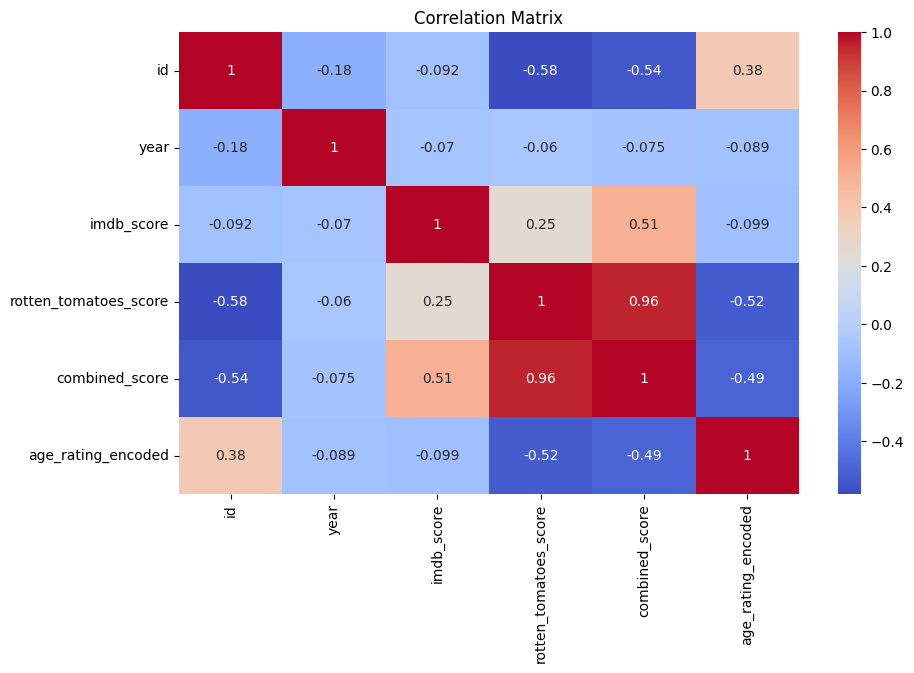

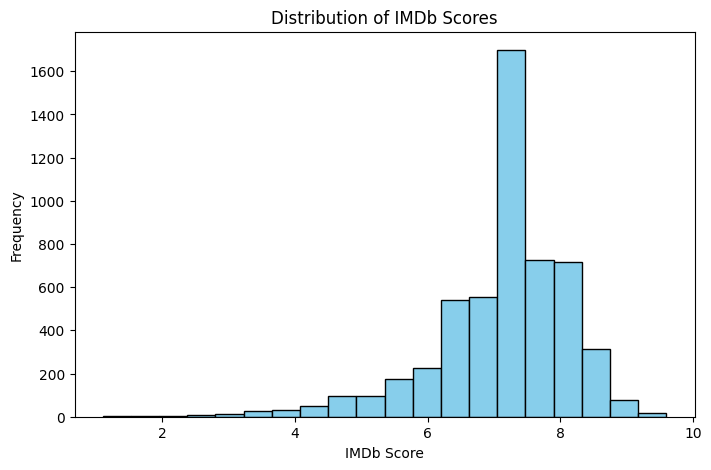

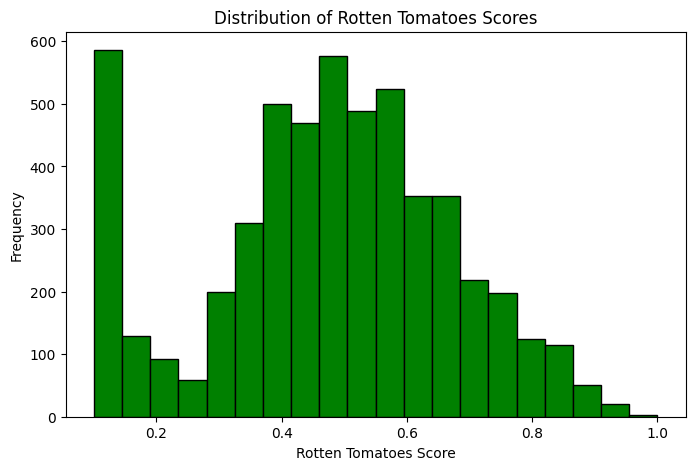

In [ ]:
# Automated EDA with ydata-profiling
from ydata_profiling import ProfileReport

profile = ProfileReport(df, title="TV Shows Dataset Report", explorative=True)
profile.to_file("tv_shows_profile.html")

# Correlation Matrix Heatmap
numeric_df = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Distribution Matrices (Histograms)
plt.figure(figsize=(8, 5))
plt.hist(df['imdb_score'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of IMDb Scores')
plt.xlabel('IMDb Score')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 5))
plt.hist(df['rotten_tomatoes_score'], bins=20, color='green', edgecolor='black')
plt.title('Distribution of Rotten Tomatoes Scores')
plt.xlabel('Rotten Tomatoes Score')
plt.ylabel('Frequency')
plt.show()

# Train/Test Split
X_original = df.drop(columns=['age_rating', 'title', 'age_rating_encoded']).select_dtypes(include=['float64', 'int64'])
y_original = df["age_rating_encoded"]
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(
    X_original, y_original, test_size=0.2, random_state=42, stratify=y_original)

In [ ]:

# Define Preprocessor and Models for Pipelines
numeric_features = ['imdb_score', 'rotten_tomatoes_score', 'combined_score']
categorical_features = ['year']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Ridge Classifier": RidgeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost Classifier": XGBClassifier()
}

### Experiment #1 ###
mlflow.set_experiment("Experiment #1: Logistic Regression with Preprocessing")
with mlflow.start_run(run_name="Logistic Regression - CV"):
    pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LogisticRegression(max_iter=1000))])
    cv_scores_lr = cross_val_score(pipeline_lr, X_train_original, y_train_original, cv=3, scoring='f1_macro')
    pipeline_lr.fit(X_train_original, y_train_original)
    accuracy_lr = pipeline_lr.score(X_test_original, y_test_original)
    mlflow.log_param("model", "Logistic Regression")
    mlflow.log_metric("accuracy", accuracy_lr)
    mlflow.log_metric("cv_mean_f1", np.mean(cv_scores_lr))
    mlflow.log_metric("cv_std_f1", np.std(cv_scores_lr))


### Experiment #2 ###

mlflow.set_experiment("Experiment #2: Multiple Classifiers")
for model_name, model in models.items():
    with mlflow.start_run(run_name=model_name):
        pipeline_model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
        cv_scores_model = cross_val_score(pipeline_model, X_train_original, y_train_original, cv=3, scoring='f1_macro')
        pipeline_model.fit(X_train_original, y_train_original)
        accuracy_model = pipeline_model.score(X_test_original, y_test_original)
        mlflow.log_param("model", model_name)
        mlflow.log_metric("accuracy", accuracy_model)
        mlflow.log_metric("cv_mean_f1", np.mean(cv_scores_model))
        mlflow.log_metric("cv_std_f1", np.std(cv_scores_model))

### Experiment #3 ###

mlflow.set_experiment("Experiment #3: Feature Engineering")
with mlflow.start_run(run_name="Feature Engineering"):
    df["combined_score"] = df["imdb_score"] * df["rotten_tomatoes_score"]
    mlflow.log_param("new_feature", "combined_score")



🏃 View run Logistic Regression - CV at: https://dagshub.com/nivesharath/python_final_proj.mlflow/#/experiments/5/runs/9a7b4bd6f9fd42ac8ed988817c9b7a0f
🧪 View experiment at: https://dagshub.com/nivesharath/python_final_proj.mlflow/#/experiments/5
🏃 View run Logistic Regression at: https://dagshub.com/nivesharath/python_final_proj.mlflow/#/experiments/6/runs/edad2654e6ad4f1a87cd9c8e8ccb60f1
🧪 View experiment at: https://dagshub.com/nivesharath/python_final_proj.mlflow/#/experiments/6
🏃 View run Ridge Classifier at: https://dagshub.com/nivesharath/python_final_proj.mlflow/#/experiments/6/runs/369a2cc3593e4c32b865127bf3a20268
🧪 View experiment at: https://dagshub.com/nivesharath/python_final_proj.mlflow/#/experiments/6
🏃 View run Random Forest at: https://dagshub.com/nivesharath/python_final_proj.mlflow/#/experiments/6/runs/a2d5a15738dc4e929bc0ae9b83de825e
🧪 View experiment at: https://dagshub.com/nivesharath/python_final_proj.mlflow/#/experiments/6
🏃 View run XGBoost Classifier at: https:

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
import mlflow

# Assuming df is already defined and preprocessed
# Drop non-numeric columns and target column to create feature matrix X and target vector y
X = df.drop(columns=['age_rating_encoded', 'title', 'age_rating']).select_dtypes(include=['float64', 'int64'])
y = df['age_rating_encoded']

# Start MLFlow Experiment #4
mlflow.set_experiment("Experiment #4: Feature Selection")

with mlflow.start_run(run_name="Feature Selection"):
    ### 1. Correlation Threshold ###
    # Calculate correlation matrix
    correlation_matrix = X.corr().abs()

    # Select upper triangle of correlation matrix
    upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

    # Find features with correlation greater than the threshold (e.g., 0.8)
    correlation_threshold = 0.8
    high_correlation_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > correlation_threshold)]

    # Log results in MLFlow
    mlflow.log_param("correlation_threshold", correlation_threshold)
    mlflow.log_param("high_correlation_features", high_correlation_features)

    print(f"Features with high correlation (>{correlation_threshold}): {high_correlation_features}")

    ### 2. Feature Importance (Random Forest) ###
    # Train a Random Forest Classifier to get feature importances
    model = RandomForestClassifier(random_state=42)
    model.fit(X, y)

    # Get feature importances
    feature_importances = model.feature_importances_
    feature_importance_dict = {feature: importance for feature, importance in zip(X.columns, feature_importances)}

    # Sort features by importance
    sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

    # Log results in MLFlow
    mlflow.log_param("feature_importances", sorted_features)

    print("Feature Importances (sorted):")
    for feature, importance in sorted_features:
        print(f"{feature}: {importance:.4f}")

    ### 3. Variance Threshold ###
    # Apply Variance Threshold to filter low-variance features
    variance_threshold_value = 0.01
    variance_selector = VarianceThreshold(threshold=variance_threshold_value)
    variance_selector.fit(X)

    # Get features that pass the variance threshold
    selected_features_variance = X.columns[variance_selector.get_support()].tolist()

    # Log results in MLFlow
    mlflow.log_param("variance_threshold", variance_threshold_value)
    mlflow.log_param("selected_features_variance", selected_features_variance)

    print(f"Features selected by Variance Threshold (>{variance_threshold_value}): {selected_features_variance}")

# End of MLFlow Run


Features with high correlation (>0.8): ['combined_score']
Feature Importances (sorted):
id: 0.2621
combined_score: 0.2229
rotten_tomatoes_score: 0.2050
year: 0.1608
imdb_score: 0.1492
Features selected by Variance Threshold (>0.01): ['id', 'year', 'imdb_score', 'rotten_tomatoes_score', 'combined_score']
🏃 View run Feature Selection at: https://dagshub.com/nivesharath/python_final_proj.mlflow/#/experiments/1/runs/eeb6d7896b2945e8a0c0f1ad58bafe6c
🧪 View experiment at: https://dagshub.com/nivesharath/python_final_proj.mlflow/#/experiments/1


Explained Variance Ratio:
[0.51404634 0.22906522 0.17030248 0.08583911 0.00074685]


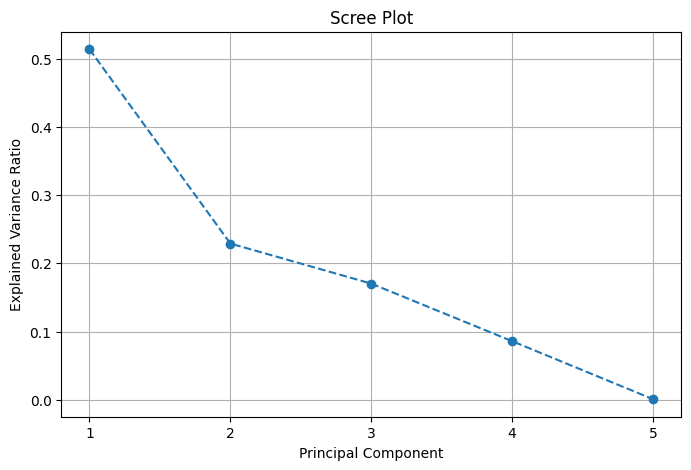

Cumulative Explained Variance:
[0.51404634 0.74311155 0.91341404 0.99925315 1.        ]
Number of components to retain: 4
🏃 View run PCA Dimensionality Reduction at: https://dagshub.com/nivesharath/python_final_proj.mlflow/#/experiments/2/runs/476dd282e1144c7993bbd4658e5e953c
🧪 View experiment at: https://dagshub.com/nivesharath/python_final_proj.mlflow/#/experiments/2


In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import mlflow

# Assuming df is already defined and preprocessed
# Drop non-numeric columns and target column to create feature matrix X
X = df.drop(columns=['age_rating_encoded', 'title', 'age_rating']).select_dtypes(include=['float64', 'int64'])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Start MLFlow Experiment #5
mlflow.set_experiment("Experiment #5: PCA for Dimensionality Reduction")

with mlflow.start_run(run_name="PCA Dimensionality Reduction"):
    ### Perform PCA ###
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)

    # Get explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_

    # Log explained variance ratio in MLFlow
    mlflow.log_param("explained_variance_ratio", explained_variance_ratio.tolist())

    print("Explained Variance Ratio:")
    print(explained_variance_ratio)

    ### Create Scree Plot ###
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.xticks(range(1, len(explained_variance_ratio) + 1))
    plt.grid(True)

    # Save the scree plot and log it in MLFlow
    scree_plot_filename = "scree_plot.png"
    plt.savefig(scree_plot_filename)
    plt.show()

    mlflow.log_artifact(scree_plot_filename)

    ### Select Principal Components ###
    # Based on the scree plot, select components that explain most of the variance (e.g., >95%)
    cumulative_variance = np.cumsum(explained_variance_ratio)

    # Log cumulative variance in MLFlow
    mlflow.log_param("cumulative_variance", cumulative_variance.tolist())

    print("Cumulative Explained Variance:")
    print(cumulative_variance)

    # Determine number of components to retain (e.g., >95% variance)
    n_components = np.argmax(cumulative_variance >= 0.95) + 1

    print(f"Number of components to retain: {n_components}")

    mlflow.log_param("n_components_selected", n_components)

    # Reduce dimensions using the selected number of components
    pca_reduced = PCA(n_components=n_components)
    X_reduced = pca_reduced.fit_transform(X_scaled)

# End of MLFlow Run


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import mlflow

# Assuming df is already defined and preprocessed
# Define X_original (features) and y_original (target)
X_original = df.drop(columns=['age_rating_encoded', 'title', 'age_rating']).select_dtypes(include=['float64', 'int64'])
y_original = df['age_rating_encoded']

# Standardize features for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_original)

# Perform PCA for dimensionality reduction
pca = PCA()
X_pca_full = pca.fit_transform(X_scaled)

# Select number of components based on cumulative variance (>95%)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.95) + 1

# Reduce dimensions using selected number of components
pca_reduced = PCA(n_components=n_components)
X_reduced = pca_reduced.fit_transform(X_scaled)

# Split original data into train/test sets
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(
    X_original, y_original, test_size=0.2, random_state=42, stratify=y_original)

# Split PCA-reduced data into train/test sets
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_reduced, y_original, test_size=0.2, random_state=42, stratify=y_original)

# Define models to evaluate
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Start MLFlow Experiment #6
mlflow.set_experiment("Experiment #6: Compare Original vs PCA Features")

for model_name, model in models.items():
    with mlflow.start_run(run_name=f"{model_name} - Original Features"):
        # Train and evaluate on original features
        model.fit(X_train_original, y_train_original)
        y_pred_original = model.predict(X_test_original)

        # Calculate metrics
        accuracy_original = accuracy_score(y_test_original, y_pred_original)
        f1_original = f1_score(y_test_original, y_pred_original, average='macro')

        # Log metrics in MLFlow
        mlflow.log_param("features", "original")
        mlflow.log_param("model", model_name)
        mlflow.log_metric("accuracy", accuracy_original)
        mlflow.log_metric("f1_score", f1_original)

        print(f"{model_name} - Original Features:")
        print(f"Accuracy: {accuracy_original:.4f}, F1-Score: {f1_original:.4f}")

    with mlflow.start_run(run_name=f"{model_name} - PCA Features"):
        # Train and evaluate on PCA-reduced features
        model.fit(X_train_pca, y_train_pca)
        y_pred_pca = model.predict(X_test_pca)

        # Calculate metrics
        accuracy_pca = accuracy_score(y_test_pca, y_pred_pca)
        f1_pca = f1_score(y_test_pca, y_pred_pca, average='macro')

        # Log metrics in MLFlow
        mlflow.log_param("features", "PCA")
        mlflow.log_param("model", model_name)
        mlflow.log_metric("accuracy", accuracy_pca)
        mlflow.log_metric("f1_score", f1_pca)

        print(f"{model_name} - PCA Features:")
        print(f"Accuracy: {accuracy_pca:.4f}, F1-Score: {f1_pca:.4f}")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression - Original Features:
Accuracy: 0.5223, F1-Score: 0.3116
🏃 View run Logistic Regression - Original Features at: https://dagshub.com/nivesharath/python_final_proj.mlflow/#/experiments/3/runs/b5733d29b29742b782b78504a4d63c01
🧪 View experiment at: https://dagshub.com/nivesharath/python_final_proj.mlflow/#/experiments/3
Logistic Regression - PCA Features:
Accuracy: 0.5158, F1-Score: 0.3074
🏃 View run Logistic Regression - PCA Features at: https://dagshub.com/nivesharath/python_final_proj.mlflow/#/experiments/3/runs/4d8a9c30c7ca41b88b20ae52ecb75e88
🧪 View experiment at: https://dagshub.com/nivesharath/python_final_proj.mlflow/#/experiments/3
Random Forest - Original Features:
Accuracy: 0.5168, F1-Score: 0.3470
🏃 View run Random Forest - Original Features at: https://dagshub.com/nivesharath/python_final_proj.mlflow/#/experiments/3/runs/57151e12acc948aa9618daec0928651d
🧪 View experiment at: https://dagshub.com/nivesharath/python_final_proj.mlflow/#/experiments/3
Random Fore

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
import mlflow

# Define parameter grids for hyperparameter tuning
param_grids = {
    "Logistic Regression": {
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__solver': ['lbfgs', 'liblinear']
    },
    "Random Forest": {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20]
    }
}

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# Ensure train/test split is defined
X = df.drop(columns=['age_rating', 'title', 'age_rating_encoded']).select_dtypes(include=['float64', 'int64'])
y = df["age_rating_encoded"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Start MLFlow Experiment #7
mlflow.set_experiment("Experiment #7: Hyperparameter Tuning")
best_model = None
for model_name, model in models.items():
    with mlflow.start_run(run_name=f"{model_name} - Hyperparameter Tuning"):
        # Create a pipeline for preprocessing and the model
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])

        # Perform GridSearchCV for hyperparameter tuning
        grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=3, scoring='f1_macro', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        # Get the best parameters and metrics
        best_params = grid_search.best_params_
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')

        # Log results in MLFlow
        mlflow.log_param("model", model_name)
        mlflow.log_param("best_params", best_params)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("f1_score", f1)

        print(f"{model_name} - Hyperparameter Tuning:")
        print(f"Best Parameters: {best_params}")
        print(f"Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}")



Logistic Regression - Hyperparameter Tuning:
Best Parameters: {'classifier__C': 10, 'classifier__solver': 'lbfgs'}
Accuracy: 0.5261, F1-Score: 0.3153
🏃 View run Logistic Regression - Hyperparameter Tuning at: https://dagshub.com/nivesharath/python_final_proj.mlflow/#/experiments/4/runs/4d8dffa01e31442a824f443c9a435ade
🧪 View experiment at: https://dagshub.com/nivesharath/python_final_proj.mlflow/#/experiments/4
Random Forest - Hyperparameter Tuning:
Best Parameters: {'classifier__max_depth': 20, 'classifier__n_estimators': 50}
Accuracy: 0.4795, F1-Score: 0.2828
🏃 View run Random Forest - Hyperparameter Tuning at: https://dagshub.com/nivesharath/python_final_proj.mlflow/#/experiments/4/runs/026ae0de18614b3fbd403b82efa90a3a
🧪 View experiment at: https://dagshub.com/nivesharath/python_final_proj.mlflow/#/experiments/4


<ipython-input-10-bdd2e700b1dd>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_df['experiment_name'] = experiment_name  # Add experiment name for identification
<ipython-input-10-bdd2e700b1dd>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_df['experiment_name'] = experiment_name  # Add experiment name for identification
<ipython-input-10-bdd2e700b1dd>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

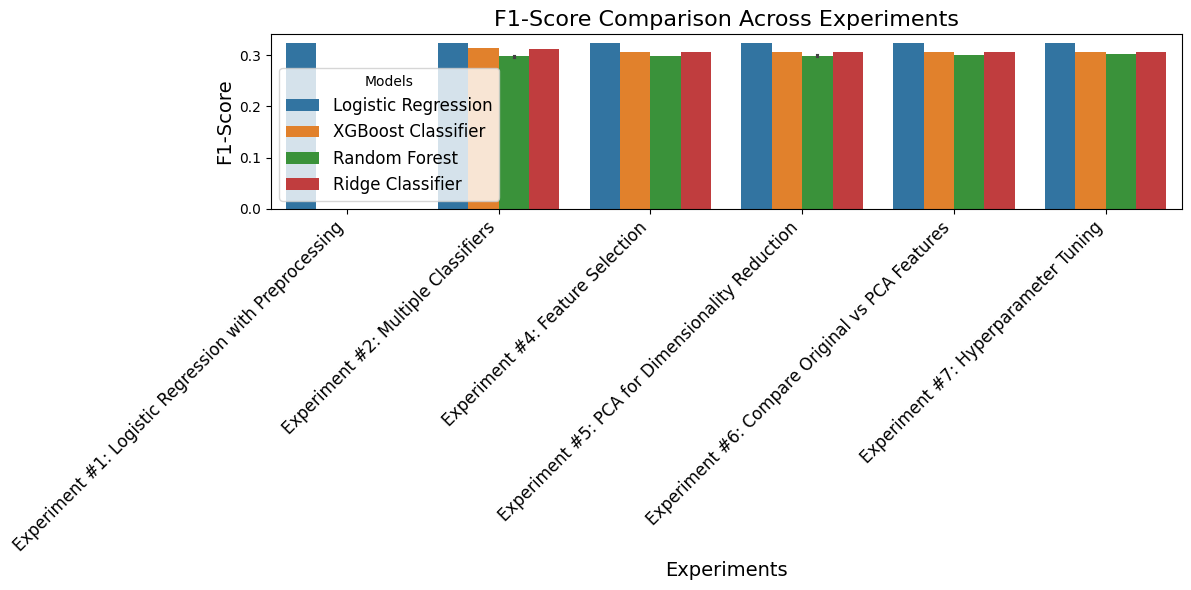

In [ ]:
import mlflow
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Retrieve Metrics from MLFlow
def get_experiment_metrics(experiment_name):
    # Get the experiment ID
    experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

    # Retrieve all runs for the experiment
    runs_df = mlflow.search_runs(experiment_ids=[experiment_id])

    # Safely handle missing columns (e.g., params.model, metrics.cv_mean_f1, metrics.accuracy)
    runs_df['params.model'] = runs_df.get('params.model', None)
    runs_df['metrics.cv_mean_f1'] = runs_df.get('metrics.cv_mean_f1', None)
    runs_df['metrics.accuracy'] = runs_df.get('metrics.accuracy', None)

    # Extract relevant metrics and parameters
    metrics_df = runs_df[['run_id', 'params.model', 'metrics.cv_mean_f1', 'metrics.accuracy']]
    metrics_df['experiment_name'] = experiment_name  # Add experiment name for identification

    return metrics_df

# List of experiments to compare
experiment_names = [
    "Experiment #1: Logistic Regression with Preprocessing",
    "Experiment #2: Multiple Classifiers",
    "Experiment #3: Feature Engineering",
    "Experiment #4: Feature Selection",
    "Experiment #5: PCA for Dimensionality Reduction",
    "Experiment #6: Compare Original vs PCA Features",
    "Experiment #7: Hyperparameter Tuning"
]

# Collect metrics for all experiments, filtering out empty experiments
all_metrics = pd.concat(
    [get_experiment_metrics(name) for name in experiment_names if mlflow.get_experiment_by_name(name) is not None],
    ignore_index=True
)

# Step 2: Organize Data for Visualization
# Filter out rows with missing F1-scores (if any)
all_metrics = all_metrics.dropna(subset=['metrics.cv_mean_f1'])
all_metrics.rename(columns={'params.model': 'Model', 'metrics.cv_mean_f1': 'F1-Score'}, inplace=True)

# Step 3: Identify Best Model Based on F1-Score
# Filter for Logistic Regression rows in the metrics DataFrame
logistic_regression_row = all_metrics[all_metrics['Model'] == "Logistic Regression"]

# Step 4: Create Bar Plots for Visualization
plt.figure(figsize=(12, 6))
sns.barplot(data=all_metrics, x='experiment_name', y='F1-Score', hue='Model')
plt.title("F1-Score Comparison Across Experiments", fontsize=16)
plt.xlabel("Experiments", fontsize=14)
plt.ylabel("F1-Score", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.legend(title="Models", fontsize=12)
plt.tight_layout()

# Save and show the plot
plt.savefig("f1_score_comparison.png")
plt.show()

In [ ]:
import joblib

# Assuming `best_model` is your final trained model
joblib.dump(best_model, "final_model.joblib")
print("Model saved as final_model.joblib")

model = joblib.load("final_model.joblib")

dummy_input = pd.DataFrame([{
    "imdb_score": 8.5,
    "rotten_tomatoes_score": 0.95,
    "combined_score": 8.075,
    "year": 2020
}])

# Make a prediction
prediction = model.predict(dummy_input)
print(prediction)
#model.feature_names_in_

Model saved as final_model.joblib
[2]
